In [42]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
data = pd.read_csv("Airports2.csv")
print(data.shape)
data.head()

(3606803, 15)


,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


In [5]:
data["Fly_year"] = data["Fly_date"].apply(lambda x: x[:4])

In [32]:
#Filtering for the nodes covered and aggregating data on a yearly basis
temp = data.groupby(['Origin_airport','Destination_airport','Fly_year']).agg({'Distance':'mean'}).reset_index()
temp = temp[temp.Distance > 0]


# Create Graph

In [33]:
def get_directed_graph_for_year(df, year):
    tem = temp[temp["Fly_year"] == year][
        ["Origin_airport", "Destination_airport", "Distance"]
    ].drop_duplicates(subset=["Origin_airport", "Destination_airport"])
    tem = tem.dropna()
    # use networkx DiGraph to create directed graph
    airport_graph = nx.from_pandas_edgelist(tem,
                                            source="Origin_airport",
                                            target="Destination_airport",
                                            edge_attr="Distance",
                                            create_using=nx.DiGraph)
    return airport_graph


# Linear Programming

## Minimum Number Of Hubs

In [9]:
from pulp import *

In [34]:
#Using PuLP to find the minimum vertex cover function for the airports served year on year

def min_hubs(G):
    """
    G: directed graph
    """
    possible_nodes = [c for c in G.nodes()]

    # create a binary variable to represent each node in the graph
    x = LpVariable.dicts(
        "Airport", possible_nodes, lowBound=0, upBound=1, cat=LpInteger
    )

    # define binary integer programming problem
    min_hubs_prob = LpProblem("Minimum_Airports", LpMinimize)

    # define objective function
    min_hubs_prob += lpSum([x[node] for node in possible_nodes])

    for a, b in G.edges:
        min_hubs_prob += (
            x[a] + x[b] >= 1, f"Include_Airports_{a}_{b}"
        )

    # solve the problem
    min_hubs_prob.solve(PULP_CBC_CMD(msg=0))

    min_hub_size = 0
    for v in min_hubs_prob.variables():
        min_hub_size += v.varValue

    return min_hub_size


# Analyse

In [35]:
#Sorting the data year wise

years = temp["Fly_year"].unique()
years.sort()

In [39]:
min_hubs_result = {}
for y in years:
    G = get_directed_graph_for_year(temp, y)
    result = min_hubs(G)
    min_hubs_result[y] = result


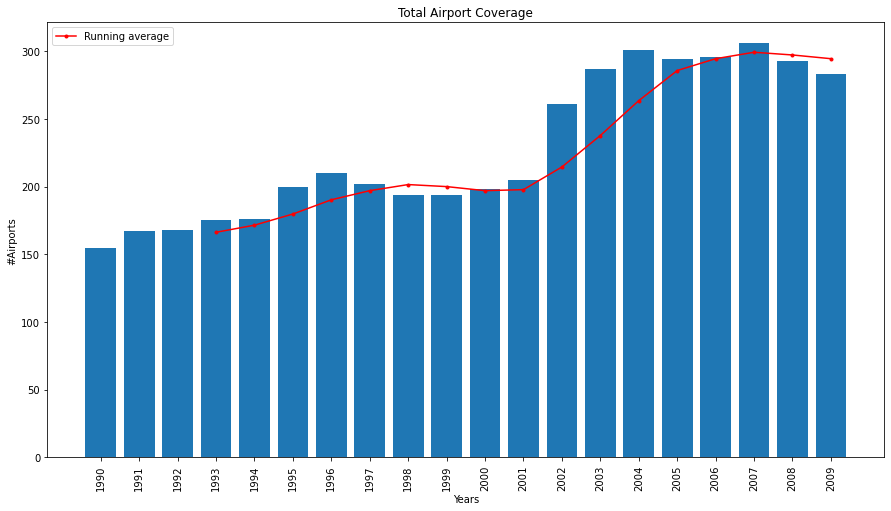

In [51]:
keys = list(min_hubs_result.keys())
values = list(min_hubs_result.values())

#moving average
window = 4

average = []

for ind in range(len(min_hubs_result) - window + 1):
    average.append(np.mean(values[ind:ind+window]))

for ind in range(window - 1):
    average.insert(0, np.nan)    
    
plt.figure(figsize=(15,8))
plt.bar(range(len(min_hubs_result)), values, tick_label=names) #Vertex Cover Plot
plt.plot(average,'r.-', label='Running average') #Running Average Line
plt.ylabel('#Airports')
plt.xlabel('Years')
plt.title("Total Airport Coverage")
plt.xticks(rotation=90)
plt.legend()
plt.show()
